In [1]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord

# %matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display
from gammapy.data import Observation, observatory_locations
from gammapy.datasets import SpectrumDataset, SpectrumDatasetOnOff, MapDataset, MapDatasetOnOff
from gammapy.estimators import SensitivityEstimator
from gammapy.irf import load_cta_irfs
from gammapy.makers import SpectrumDatasetMaker, MapDatasetMaker
from gammapy.maps import MapAxis, RegionGeom, Map, WcsGeom, RegionNDMap
from gammapy.modeling.models import (
    TemplateSpatialModel, PowerLawNormSpectralModel, SkyModel, FoVBackgroundModel, Models, 
    PowerLawSpectralModel, GaussianSpatialModel
)

In [2]:
energy_axis = MapAxis.from_energy_bounds("0.03 TeV", "30 TeV", nbin=20)
energy_axis_true = MapAxis.from_energy_bounds(
    "0.01 TeV", "100 TeV", nbin=100, name="energy_true"
)
migra_axis = MapAxis.from_bounds(
    0.5, 2, nbin=150, node_type="edges", name="migra"
)



livetime = 50.0 * u.hr

source_coord = SkyCoord.from_name("Geminga")

# geom = RegionGeom.create(
#     f"icrs;circle({source_coord.ra.deg - 0.1}, {source_coord.dec.deg}, 10)", 
#     # binsz_wcs=0.02 * u.deg,
#     axes=[energy_axis])
# geom = RegionGeom.create(f"icrs;circle({source_coord.ra.deg - 0.1}, {source_coord.dec.deg}, 100)", axes=[energy_axis], binsz_wcs=0.02 * u.deg)

pointing = source_coord


geom = WcsGeom.create(
    skydir=pointing,
    width=(2, 2),
    binsz=0.02,
    frame="icrs",
    axes=[energy_axis, energy_axis_true],
)

empty_dataset = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

geom

WcsGeom

	axes       : ['lon', 'lat', 'energy', 'energy_true']
	shape      : (100, 100, 20, 100)
	ndim       : 4
	frame      : icrs
	projection : CAR
	center     : 98.5 deg, 17.8 deg
	width      : 2.0 deg x 2.0 deg
	wcs ref    : 98.5 deg, 17.8 deg

In [3]:
geom

WcsGeom

	axes       : ['lon', 'lat', 'energy', 'energy_true']
	shape      : (100, 100, 20, 100)
	ndim       : 4
	frame      : icrs
	projection : CAR
	center     : 98.5 deg, 17.8 deg
	width      : 2.0 deg x 2.0 deg
	wcs ref    : 98.5 deg, 17.8 deg

In [4]:
irfs = load_cta_irfs(
    # "$GAMMAPY_DATA/1.0/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits",
    "./Prod5-South-20deg-SouthAz-14MSTs37SSTs.18000s-v0.1.fits.gz"
    # "$GAMMAPY_DATA/1.0/cta-caldb/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz"
)
location = observatory_locations["cta_south"]
pointing = SkyCoord.from_name("Geminga")


In [6]:
obs = Observation.create(
    pointing=pointing, irfs=irfs, livetime=livetime, location=location
)

spectrum_maker = SpectrumDatasetMaker(selection=["exposure", "edisp", "background"])
# spectrum_dataset = spectrum_maker.run(empty_dataset, obs)

containment = 0.68

# correct exposure
# spectrum_dataset.exposure *= containment

# correct background estimation
on_radii = obs.psf.containment_radius(
    energy_true=energy_axis.center, offset=0.5 * u.deg, fraction=containment
)
# factor = (1 - np.cos(on_radii)) / (1 - np.cos(geom.width))
# spectrum_dataset.background *= factor.value.reshape(spectrum_dataset.background.data.shape)


In [7]:
filename = "allenergies_TeV.fits"
m = Map.read(filename)

m = m.copy(unit="1 / (cm2 TeV s sr)")

spatial_model = TemplateSpatialModel(m, filename=filename, normalize=False)
# spatial_model = GaussianSpatialModel(lon_0=source_coord.ra, lat_0=source_coord.dec, sigma="0.5 deg", frame="icrs")
# Geminga_model = SkyModel(spectral_model=PowerLawNormSpectralModel(), spatial_model=spatial_model, name="Geminga-template-model")
# Geminga_model = SkyModel(spectral_model=PowerLawSpectralModel(amplitude=5e-10/u.cm**2/u.s/u.TeV), spatial_model=spatial_model, name="Geminga-template-model")
Geminga_model = SkyModel(spectral_model=PowerLawNormSpectralModel(amplitude=1/u.cm**2/u.s/u.TeV), spatial_model=spatial_model, name="Geminga-template-model")


# m.plot_grid()

# bkg_spectral_model = PowerLawSpectralModel(
#     index=2.7, amplitude="1e6 cm-2 s-1 TeV-1", reference="1 TeV")

bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")
#bkg_model = FoVBackgroundModel(spectral_model=bkg_spectral_model, dataset_name="dataset-simu")

#models = Models([bkg_model])
models = Models([Geminga_model,bkg_model])
print(models)

print(models.to_yaml())

Template file already exits, and overwrite is False


Models

Component 0: SkyModel

  Name                      : Geminga-template-model
  Datasets names            : None
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : TemplateSpatialModel
  Temporal model type       : 
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         


components:
-   name: Geminga-template-model
    type: SkyModel
    spectral:
        type: PowerLawNormSpectralModel

In [ ]:
# Geminga_model.integrate_geom(RegionGeom.create(f"icrs;circle({source_coord.ra.deg - 0.1}, {source_coord.dec.deg}, 100)", 
#     axes=[energy_axis, energy_axis_true], 
#     binsz_wcs=0.02 * u.deg))

[]

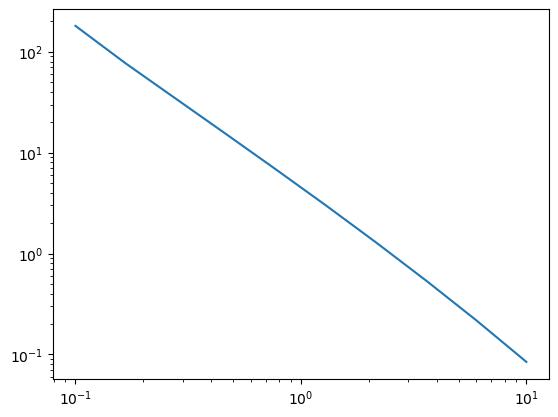

In [15]:
en = np.logspace(-1,1, 10)*u.TeV
flux = ((Geminga_model.evaluate(source_coord.ra, source_coord.dec, energy=en)*1*u.TeV*1*u.TeV).to(u.eV/u.cm**2/u.s/u.sr)*((3*u.deg)**2)).\
    to(u.eV/u.cm**2/u.s)

plt.plot(
    en,
    flux
)

plt.loglog()

In [ ]:
Geminga_model.spectral_model.plot(energy_bounds=[1*u.TeV, 10*u.TeV]) #.to(u.erg) #/u.cm**2/u.s)

In [ ]:
empty = MapDataset.create(geom, energy_axis_true=energy_axis_true, migra_axis=migra_axis, name="dataset-simu")

obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

# maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=5.0 * u.deg)

dataset = maker.run(empty, obs)
# dataset = maker_safe_mask.run(dataset, obs)

dataset.models = models

dataset.fake()

print(dataset)

dataset.peek()

In [ ]:
dataset.models.parameters.to_table()

In [ ]:
list(dir(dataset.models))

In [ ]:
dataset_on_off = MapDatasetOnOff.from_map_dataset(
    dataset=dataset, acceptance=.1, acceptance_off=5
)

dataset_spectrum_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=spectrum_dataset, acceptance=1, acceptance_off=5
)

dataset_on_off.counts.data.max(), dataset_on_off.counts_off.data.max()

In [ ]:
dataset_on_off.peek()

In [ ]:
dataset.counts.get_spectrum().plot(label="average")

# dataset_on_off.counts_off.get_spectrum().plot(label="off")
# dataset_on_off.npred_signal().get_spectrum().plot(label="on")
plt.legend()


In [ ]:
sensitivity_estimator = SensitivityEstimator(
    gamma_min=10, n_sigma=5, bkg_syst_fraction=0.10
)
sensitivity_table = sensitivity_estimator.run(dataset_on_off)

In [ ]:
sensitivity_table['excess']

In [ ]:
dataset_on_off.counts.data

In [ ]:

spectrum_sensitivity_estimator = SensitivityEstimator(
    gamma_min=10, n_sigma=5, bkg_syst_fraction=0.10, 
    # spectrum= PowerLawSpectralModel(index=2.7, amplitude="1 cm-2 s-1 TeV-1")
    # spectrum=Geminga_model.spectral_model
)
spectrum_sensitivity_table= spectrum_sensitivity_estimator.run(dataset_spectrum_on_off)

In [ ]:
emin_cta, flux_cta = np.loadtxt('CTA_point_source_left.txt',unpack=True) # E[TeV], E^2 * Flux Sensitivity [erg cm^2/s]
emax_cta, flux_cta = np.loadtxt('CTA_point_source_right.txt',unpack=True)
emean_cta, flux_cta = np.loadtxt('CTA_point_source_mean.txt',unpack=True)

In [ ]:
# check this out, data for 
# https://zenodo.org/record/5499840#.YUya5WYzbUI
# https://docs.gammapy.org/1.0.1/tutorials/analysis-1d/cta_sensitivity.html?highlight=sensitivity

In [ ]:
# Show the results table
display(sensitivity_table)

# Save it to file (could use e.g. format of CSV or ECSV or FITS)
# sensitivity_table.write('sensitivity.ecsv', format='ascii.ecsv')

# Plot the sensitivity curve
t = sensitivity_table

is_s = t["criterion"] == "significance"

fig, ax = plt.subplots()
ax.plot(
    spectrum_sensitivity_table["energy"],    
    spectrum_sensitivity_table["e2dnde"],
    "s-",
    color="black",
    label="spectrum dtaset",
)

ax.plot(
    t["energy"][is_s],
    t["e2dnde"][is_s],
    "s-",
    color="red",
    label="significance",
)

is_g = t["criterion"] == "gamma"
ax.plot(t["energy"][is_g], t["e2dnde"][is_g], "*-", color="blue", label="gamma")
is_bkg_syst = t["criterion"] == "bkg"
ax.plot(
    t["energy"][is_bkg_syst],
    t["e2dnde"][is_bkg_syst],
    "v-",
    color="green",
    label="bkg syst",
)

plt.errorbar(emean_cta[2:-1],flux_cta[2:-1],label='CTA point source 50h')


ax.loglog()
ax.set_xlabel(f"Energy [{t['energy'].unit}]")
ax.set_ylabel(f"Sensitivity [{t['e2dnde'].unit}]")
ax.legend()

In [ ]:
# Plot expected number of counts for signal and background
fig, ax1 = plt.subplots()
# ax1.plot( t["energy"], t["excess"],"o-", color="red", label="signal")
ax1.plot(t["energy"], t["background"], "o-", color="black", label="blackground")

ax1.loglog()
ax1.set_xlabel(f"Energy [{t['energy'].unit}]")
ax1.set_ylabel("Expected number of bkg counts")

ax2 = ax1.twinx()
ax2.set_ylabel(f"ON region radius [{on_radii.unit}]", color="red")
ax2.semilogy(t["energy"], on_radii, color="red", label="PSF68")
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(0.01, 0.5)
plt.show()